In [2]:
import time
import os
import re
from PIL import Image


In [3]:
football_clubs=['Barcelona', 'Real Madrid', 'Manchester United', 'Borussia Dortmund','Inter Milan', 'Chelsea'] #hagar

cars = ['Alfa Romeo', 'Audi', 'BMW', 'Chevrolet', 'Citroen', 'Dacia', 'Daewoo', 'Dodge',
        'Ferrari', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Jaguar', 'Jeep', 'Kia', 'Lada',
        'Lancia', 'Land Rover', 'Lexus', 'Maserati', 'Mazda', 'Mercedes', 'Mitsubishi',
        'Nissan', 'Opel', 'Peugeot', 'Porsche', 'Renault', 'Rover', 'Saab', 'Seat',
        'Skoda', 'Subaru', 'Suzuki', 'Tata', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo']



# Working with images

In [4]:
# Importing standard ML set - numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Importing keras and its deep learning tools - neural network model, layers, contraints, optimizers, callbacks and utilities
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.regularizers import l2
from keras.initializers import RandomNormal, VarianceScaling
import natsort
# Importing scikit-learn tools
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

ModuleNotFoundError: No module named 'natsort'

In [ ]:
# Setting up the image pool
#hagar allll
image_path = 'images/'
images = os.listdir(image_path)
img_x = img_y = 224 # image size is constant
imgs=[]

for image in images:
    i=int(image.split('.')[0])
    imgs.append(i)
imgs=sorted(imgs)
imgs= [str(i) + ".jpg " for i in imgs ]
imgs[45]="46.png"
print( imgs )

n_samples = np.size(imgs)
n_samples


In [76]:
# Loading all images...
images = np.array([np.array(Image.open(image_path + img).convert("RGB")).flatten() for img in imgs], order='F', dtype='uint8')
np.shape(images)

(300, 150528)

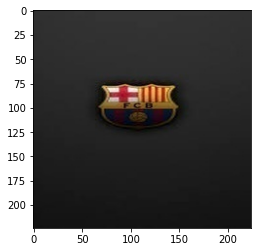

In [77]:
# an example image
plt.imshow(images[2].reshape(img_x, img_y, 3))


In [78]:
# Producing labels and assigning them accordingly
#hagar all
labels=[]
           
for n in range(300):
            if n < 50:  #Barca
                labels.append(0)    
            elif n >= 50 and n < 100:
                labels.append(1)    #RMA
            elif n >= 100 and n < 150:
                labels.append(2)    #ManU
            elif n >= 150 and n < 200:
                labels.append(3)    #BVB
            elif n >= 200 and n < 250:
                labels.append(4)    #Inter
            else:
                labels.append(5) 

labels = np.array(labels)
labels.shape

(300,)

In [88]:
# Some additional data preparation needs to be done before blasting the images into the neural net
dataset, labelset = shuffle(images, labels, random_state=42) # 42, what else? ;)
train_data = [dataset, labelset]

In [89]:
# Testing if the images loaded up okay - 500 should show Alfa Romeo label and a five-logo image
r = 5
print(train_data[0].shape, train_data[1].shape)
plt.imshow(images[r].reshape(img_x, img_y, 3))
plt.title(football_clubs[labels[r]])
plt.show()

(300, 150528) (300,)


# Training - preparing the dataset

In [90]:
# We have to prepare the dataset to fit into the CNN
X_train, X_test, y_train, y_test = train_test_split(train_data[0], train_data[1], test_size=0.2)

# we will maintain a copy of the test set, as we will do a couple of transformation to it
X_test_img = X_test.copy()

# let's bring back the images, like above
X_train = X_train.reshape(X_train.shape[0], img_x, img_y, 3)
X_test = X_test.reshape(X_test.shape[0], img_x, img_y, 3)

# Now for some convergence-friendly procedure (is supposed to converge a lot faster when brought to 0-1 float)...
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# ...and some additional pre-processing, to zero-center the data...
X_train = np.subtract(X_train, 0.5)
X_test = np.subtract(X_test, 0.5)

# ...and to scale it to (-1, 1)
X_train = np.multiply(X_train, 2.0)
X_test = np.multiply(X_test, 2.0)

# Labels have to be transformed to categorical
Y_train = np_utils.to_categorical(y_train, num_classes=len(football_clubs))
Y_test = np_utils.to_categorical(y_test, num_classes=len(football_clubs))

In [91]:
# All should be okay, but we still need some heavy data augmentation, as 20k samples with 40 labels is a bit too few...
X_train.shape, X_test.shape

((240, 224, 224, 3), (60, 224, 224, 3))

# Data augmentation

In [92]:
# In order to process data augmentation, keras' ImageDataGenerator can apply some transformations to images on random
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [93]:
# It has to be 'fit' into the training set, which will take a while...
datagen.fit(X_train)
print('done')

done


# Building the CNN model

In [94]:
# Finally for some CNN construction!

# setting up batch size
batch = 128

# there are 40 brands altogether, so far, but let's make it official
n_classes = len(football_clubs)

# setting up the number of epochs to be trained
n_epochs = 200

# images are RGB, so they use up 3 channels for Red, Green and Blue, respectively
n_channels = 3

In [1]:
# Convolutional Neural Network will be composed of four Conv/MaxPool blocks, a flattening layer and two dense layers at the end
# (before the final classification layer, that is)

# The model will have a sequential architecture
# NOTE: kernel and bias had to be fine-tuned in order to increase the chance of converging

model = Sequential()
model.add(Conv2D(32, (3,3),
                 input_shape=(img_x,img_y,n_channels),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
model.add(Dropout(0.5))

# final activation is softmax, tuned to the number of classes/labels possible
model.add(Dense(len(football_clubs), activation='softmax'))

# Some callbacks have to be provided to choose the best trained model
# patience set at 4 as 3 was too greedy - I observed better results after the third-worse epoch
early_stopping = EarlyStopping(patience=4, monitor='val_loss')
CNN_file = 'football_CNN_13AUGM_CMCMCMCMF.h5py' # the 13th try, with augmented data
take_best_model = ModelCheckpoint(CNN_file, save_best_only=True)

# optimizer will be a stochastic gradient descent, learning rate set at 0.005
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])

# Let's look at the summary
model.summary()

NameError: name 'Sequential' is not defined

# Applying ImageDataGenerator - training with the augmented dataset
A note has to be made here: I tried to use the regular .fit() method, but probably due to unbalanced and relatively small dataset, it reached the accuracy of some 72%-73% at best, with the loss on the validation set at some 1.2 at best.
Using the virtually augmented dataset boosted the accuracy score beyond 80% and lowered the val_loss parameter below 1.0. I assumed and saved the best trained model.

In [97]:
# Training time was around 4 minutes per epoch, restarting a few times - over 16 hours overall
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch, shuffle=True, seed=42),
                    steps_per_epoch=X_train.shape[0]//batch, epochs=n_epochs,
                    validation_data=(X_test, Y_test), workers=4)

Epoch 1/200
1/1 [==============================] - 12s 12s/step - loss: 1.0277 - categorical_accuracy: 0.6484 - val_loss: 1.1326 - val_categorical_accuracy: 0.6167
Epoch 2/200
1/1 [==============================] - 11s 11s/step - loss: 1.0747 - categorical_accuracy: 0.5804 - val_loss: 1.1101 - val_categorical_accuracy: 0.6167
Epoch 3/200
1/1 [==============================] - 12s 12s/step - loss: 1.0286 - categorical_accuracy: 0.6250 - val_loss: 1.0923 - val_categorical_accuracy: 0.6833
Epoch 4/200
1/1 [==============================] - 12s 12s/step - loss: 1.0203 - categorical_accuracy: 0.6484 - val_loss: 1.1165 - val_categorical_accuracy: 0.6167
Epoch 5/200
1/1 [==============================] - 12s 12s/step - loss: 1.0653 - categorical_accuracy: 0.6016 - val_loss: 1.1200 - val_categorical_accuracy: 0.7000
Epoch 6/200
1/1 [==============================] - 11s 11s/step - loss: 1.0094 - categorical_accuracy: 0.5982 - val_loss: 1.0766 - val_categorical_accuracy: 0.7167
Epoch 7/200
1/1 

Epoch 51/200
1/1 [==============================] - 11s 11s/step - loss: 0.6183 - categorical_accuracy: 0.7857 - val_loss: 0.9730 - val_categorical_accuracy: 0.8000
Epoch 52/200
1/1 [==============================] - 12s 12s/step - loss: 0.6819 - categorical_accuracy: 0.7734 - val_loss: 0.9769 - val_categorical_accuracy: 0.7833
Epoch 53/200
1/1 [==============================] - 11s 11s/step - loss: 0.6769 - categorical_accuracy: 0.7422 - val_loss: 0.9690 - val_categorical_accuracy: 0.7667
Epoch 54/200
1/1 [==============================] - 11s 11s/step - loss: 0.6838 - categorical_accuracy: 0.7321 - val_loss: 1.0294 - val_categorical_accuracy: 0.7667
Epoch 55/200
1/1 [==============================] - 11s 11s/step - loss: 0.7615 - categorical_accuracy: 0.7768 - val_loss: 0.9641 - val_categorical_accuracy: 0.7833
Epoch 56/200
1/1 [==============================] - 11s 11s/step - loss: 0.6535 - categorical_accuracy: 0.8036 - val_loss: 0.9767 - val_categorical_accuracy: 0.7500
Epoch 57/2

Epoch 101/200
1/1 [==============================] - 11s 11s/step - loss: 0.3823 - categorical_accuracy: 0.8984 - val_loss: 1.0901 - val_categorical_accuracy: 0.7333
Epoch 102/200
1/1 [==============================] - 12s 12s/step - loss: 0.4604 - categorical_accuracy: 0.8516 - val_loss: 0.9598 - val_categorical_accuracy: 0.7833
Epoch 103/200
1/1 [==============================] - 12s 12s/step - loss: 0.5136 - categorical_accuracy: 0.8203 - val_loss: 1.2982 - val_categorical_accuracy: 0.7500
Epoch 104/200
1/1 [==============================] - 12s 12s/step - loss: 0.5086 - categorical_accuracy: 0.8203 - val_loss: 1.0901 - val_categorical_accuracy: 0.7667
Epoch 105/200
1/1 [==============================] - 11s 11s/step - loss: 0.4762 - categorical_accuracy: 0.8304 - val_loss: 0.9831 - val_categorical_accuracy: 0.7833
Epoch 106/200
1/1 [==============================] - 11s 11s/step - loss: 0.3324 - categorical_accuracy: 0.9018 - val_loss: 0.9520 - val_categorical_accuracy: 0.8000
Epoc

1/1 [==============================] - 12s 12s/step - loss: 0.2244 - categorical_accuracy: 0.9375 - val_loss: 0.9372 - val_categorical_accuracy: 0.7833
Epoch 200/200
1/1 [==============================] - 12s 12s/step - loss: 0.2716 - categorical_accuracy: 0.9286 - val_loss: 1.0412 - val_categorical_accuracy: 0.8167


In [112]:
# that 'little' file (~145MB) just cost me 16 hours to produce, so it's better to load it now
#model.load_weights('football_CNN_13AUGM_CMCMCMCMF.h5py')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for football_CNN_13AUGM_CMCMCMCMF.h5py

In [99]:
X_train.shape

(240, 224, 224, 3)

In [100]:
# I will need that later to re-convert my flattened images to their previous state
def ImageConvert(n, i):
    im_ex = i.reshape(n, img_x, img_y, 3)
    im_ex = im_ex.astype('float32') / 255
    im_ex = np.subtract(im_ex, 0.5)
    im_ex = np.multiply(im_ex, 2.0)
    return im_ex

In [101]:
# Just for reference, I leave the output of the regular (no augmentation) .fit()

In [119]:
# model.fit(X_train, Y_train, batch_size=batch, shuffle=True, epochs=n_epochs, verbose=1, validation_data=(X_test, Y_test),
#          callbacks=[early_stopping, take_best_model])
import tensorflow as tf
tf.saved_model.save(model ,'C:/Users/amr essam/Desktop/Windows Data Part/image_proj/')

INFO:tensorflow:Assets written to: C:/Users/amr essam/Desktop/Windows Data Part/image_proj/assets


In [122]:

model = tf.saved_model.load('C:/Users/amr essam/Desktop/Windows Data Part/image_proj/')


In [124]:
print(model.shape)
#scores = model.evaluate(X_test, Y_test) # let's look at the accuracy on the test set

#print("Accuracy test: %.2f%%" % (scores[1]*100))

AttributeError: '_UserObject' object has no attribute 'shape'

# Showcasing

In [108]:
# OK, let's try the CNN in action - first defining the ShowCase() method to show everything nicely

def ShowCase(cols, rows):
    fdict = {'fontsize': 24,
            'fontweight' : 'normal',
            'verticalalignment': 'baseline'}
    plt.figure(figsize=(cols * 5, rows * 4))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    c = 0
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        
        # r - randomly picked from the whole dataset
        r = np.random.randint(np.shape(images)[0])
        
        # j - predicted class for the image of index r (weird syntax, but works :)
        j = int(model.predict_classes(ImageConvert(1, images[r:r+1]), verbose=0))
        
        # increase success if predicted well
        if labels[r] == j:
            c += 1
        
        # image needs reshaping back to a 50px*50px*RGB
        plt.imshow(images[r].reshape(img_x, img_y, 3))
        
        # plt.title will show the true brand and the predicted brand
        plt.title('True brand: '+football_clubs[labels[r]]+'\nPredicted: '+football_clubs[j],
                  color= 'Green' if football_clubs[labels[r]] == football_clubs[j] else 'Red', fontdict=fdict) # Green for right, Red for wrong
        
        # no ticks
        plt.xticks(())
        plt.yticks(())
        
    # print out the success rate
    print('Success rate: {}/{} ({:.2%})'.format(c, rows*cols, c/(rows*cols)))
    
    plt.show()

In [109]:
# That is strictly for the showcasing, how the CNN works - ain't that bad, after all :)
ShowCase(10, 5)

c:\users\amr essam\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Success rate: 47/50 (94.00%)


<hr>

# New input - testing beyond the test set

Let's try to test CarL-CNN in the wild - I went down to the garage and took a picture of every car there. I tried to acquire pictures from different angles and with different lighting. I put it into the new_images folder, never touched by CarL.

In [30]:
# Setting up the image pool
new_image_path = 'new_images/'
new_imgs = os.listdir(new_image_path)
new_n_samples = np.size(new_imgs)
new_n_samples # 8

8

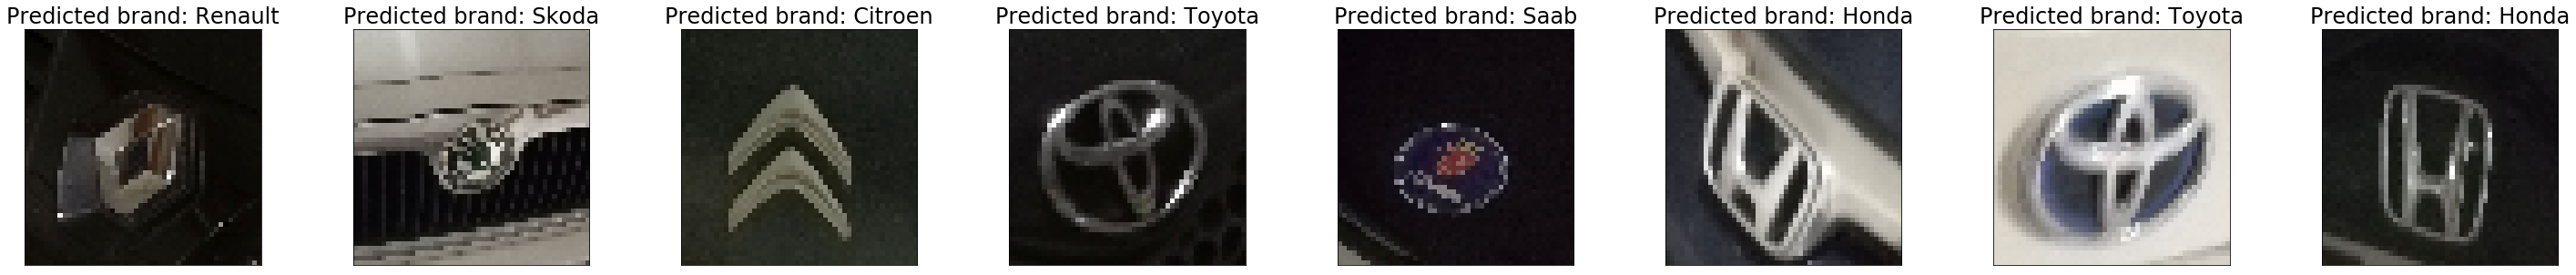

In [31]:
# Let's do some showcasing on-the-fly....
cols = 8
rows = 1
plt.figure(figsize=(cols * 5, rows * 4))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(new_n_samples):
    plt.subplot(rows, cols, i + 1)
    im = Image.open(new_image_path+new_imgs[i]).convert("RGB")
    new_im = np.array(im.resize((50,50))).flatten()
    m = int(model.predict_classes(ImageConvert(1, new_im), verbose=0))
    plt.imshow(new_im.reshape(img_x, img_y, 3))
    plt.title('Predicted brand: '+cars[m], size=24)
    plt.xticks(())
    plt.yticks(())
plt.show()

# 100% success! :)

<hr>

# Examining the bad ones
Let's also see the wrongly predicted classes - try to judge what could be the reason - were they really "similar" to the predicted brands?

In [32]:
# let's extract the bad ones...
bad_ones = []

for i in range(len(X_test)):
    if y_test[i] != Y_pred[i]:
        bad_ones.append(i)

len(bad_ones)

232

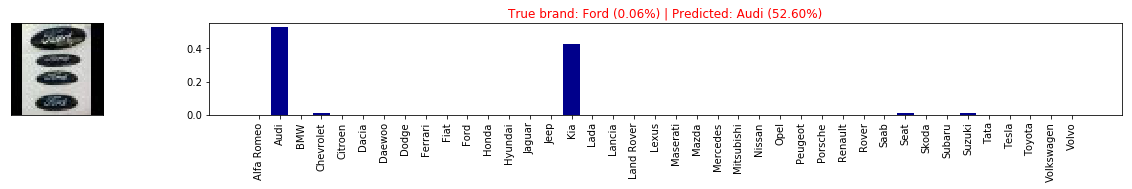

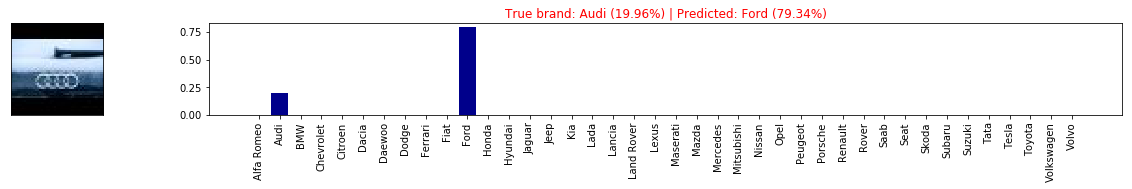

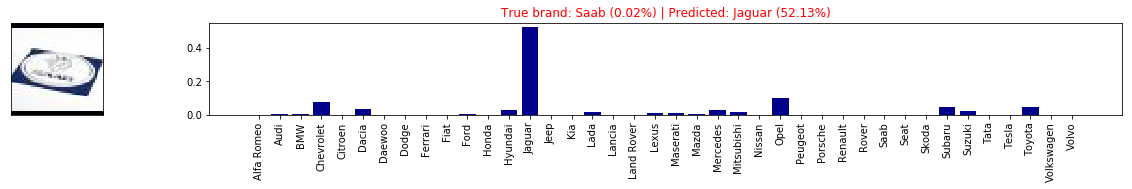

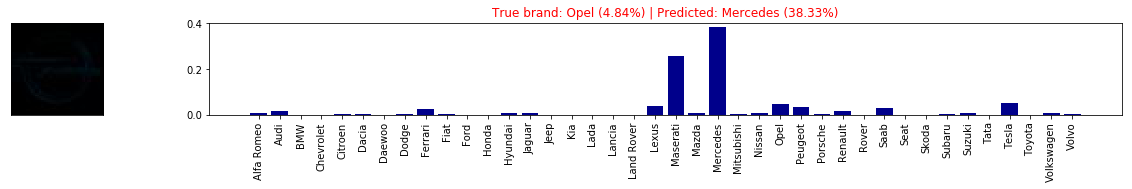

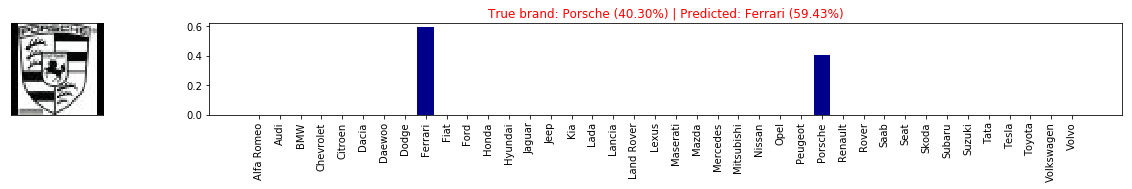

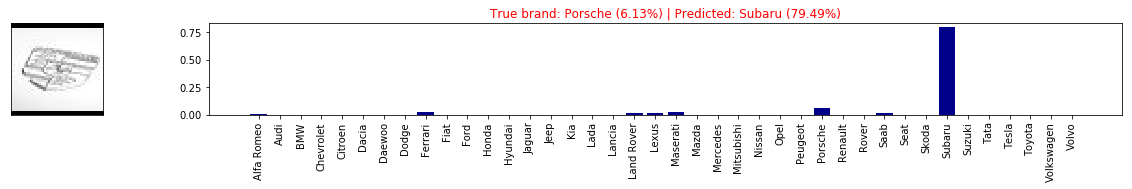

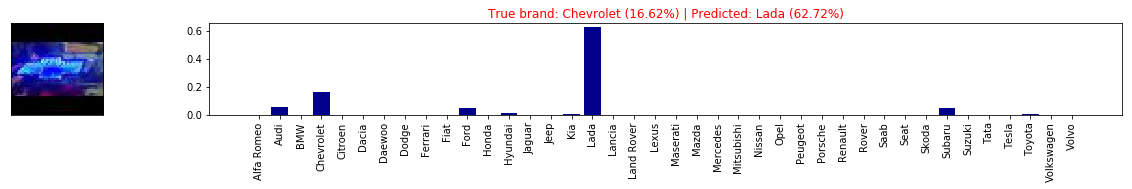

In [33]:
# ...now let's see them
samples = 10

fdict = {'fontsize': 12,
        'fontweight' : 'normal',
        'verticalalignment': 'baseline'}

for i in range(samples):
    
    # randomly choose only from the test set
    r = np.random.choice(bad_ones)
    
    # a list of probability predictions (brand classification)
    probs = model.predict_proba(X_test[r:r+1], verbose=0)[0]
    
    # we will still need the class predicted by the model
    j = int(model.predict_classes(X_test[r:r+1], verbose=0))
    
    x = range(len(cars))
    plt.figure(figsize=(20, samples * 2))
    
    # gridspec will handle the subplots nicely - we need only a small fraction for image show, but a long one for all 40 classes
    grid = gridspec.GridSpec(samples, 2, width_ratios=[1,9])
    plt.subplot(grid[0])
    
    # here we use X_test_img - the untouched copy of X_test
    plt.imshow(X_test_img[r].reshape(img_x, img_y, 3))
    
    # loose the ticks in the image subplots
    plt.xticks(())
    plt.yticks(())
    plt.subplot(grid[1])
    
    # the title shows the True brand and its predicted probability and the Predicted brand (and its predicted probability, too)
    plt.title('True brand: ' + cars[y_test[r]] + " ({:.2%})".format(probs[y_test[r]]) +
              ' | Predicted: ' + cars[j] + " ({:.2%})".format(probs[j]),
              color= 'Green' if cars[y_test[r]] == cars[j] else 'Red', fontdict=fdict) # again: GreenIsGood/RedIsBad
    plt.bar(x, probs, color='DarkBlue')
    plt.xticks(x, cars, rotation = 90)
plt.show()

Some of those examples were iffy for me too. But sometimes the neural network just totally missed!
Perhaps an even more diversified, less hand-picked and more noisy training dataset would help...

Anyhow, let's see the full statistics -- which were the most frequently confused brands? Which class datasets might need further augmenting and perhaps diversification before training the model again?

In [34]:
bad_list = [0] * len(cars)
for i in y_test[bad_ones]:
    bad_list[i] += 1
plt.figure(figsize=(15,6))
plt.bar(x, bad_list, color='Gray')
plt.xticks(x, cars, rotation = 90)
plt.show()

So, Hyundai, Volkswagen and Chevrolet were most often confused with other brands, now let's see with which, each:

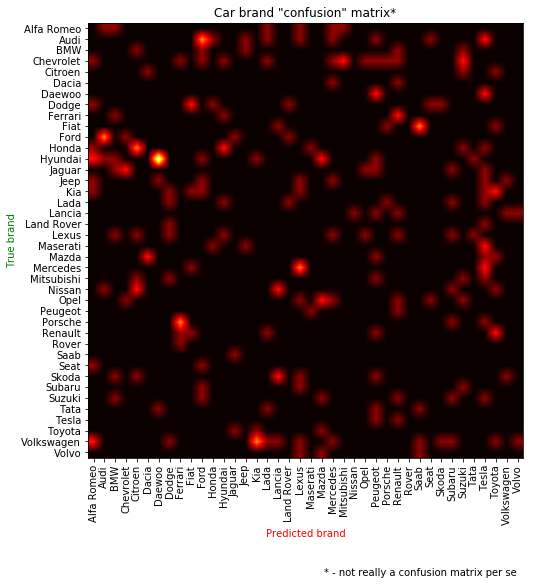

In [35]:
# Let's construct our own "confusion matrix" (not to be )
bD = np.zeros((40, 40))
for i in bad_ones:
    bD[y_test[i], Y_pred[i]] += 1

plt.figure(figsize=(8,8))
plt.imshow(bD, interpolation='bilinear', cmap='hot')
plt.xticks(x, cars, rotation=90)
plt.yticks(x, cars)
plt.title('Car brand "confusion" matrix*')
plt.xlabel('Predicted brand', color='Red')
plt.ylabel('True brand', color='Green')
plt.figtext(0.88,-0.08, '* - not really a confusion matrix per se', horizontalalignment='right')
plt.show()

The most significant error for CarL was mistaking Hyundai for Daewoo (although results might vary between executions).
What's interesting - it doesn't necessarily work the other way round - Daewoo was seldom mistaken for Hyundai.